# Lab4.2 Testing and evaluating an emotion classifier

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

We explained in class why researchers create separate train, development (dev) and test splits for their data. This allows researchers to experiment with the training data by testing on the development set but report the final performance on the test set. This is to prevent optimising the paramters on the test set. Other researchers can do the same and the test results can be compared because they are from the same unseen test set.

In this notebook **Lab3.2.train-emotion-detection-bow.ipynb** of Lab3, we trained an SVM classifier with the MELD training data. In this notebook, we will load the models again and test and evaluate their performance. For this we will use the test data that is provided by the MELD project.

To learn about the properties and quality of a classifier and any other language processing model, we need to analyse:

1. The training data it was build from
2. The test data it has been tested on
3. The performance of the model on the test data
4. The confusion among categories in the predications that the model makes

We will first analyse the label distribution of both the train and test data. For this we will use visualisations of the data. We next represent the test data according to the vectorizers that were built before and give these to the classifier to make the predictions. We use the sklearn evaluation functions measure the performance against the gold labels for the test set and we generate a confusion matrix to analyse this performance. Fianally, we adjust the distribution in the training data to address data distribution biases.

## 1. Loading the train and test data

We load the data from the  ```Lab3.machine_learning/data/MELD``` folder:

* dev_sent_emo.csv
* test_sent_emo.csv
* train_sent_emo.csv

We will load the data from the train and test file in Pandas to analyse the data distribution.

In [2]:
import pandas as pd

In [3]:
filepath = '../Lab3.machine_learning/data/MELD/train_sent_emo.csv'
# Create a dataframe object 'dftrain' by readig the file.
dftrain = pd.read_csv(filepath)
filepath = '../Lab3.machine_learning/data/MELD/test_sent_emo.csv'
# Create a dataframe object 'dtest' by readig the file.
dftest = pd.read_csv(filepath)

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


In [5]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


## Loading the trained classifier

In [ ]:
# the countvectorizer
filename_vectorizer = '../lab3.machine_learning/models/utterance_vectorizer.sav'
# the tfidf transformer
filename_tfidftransformer = '../lab3.machine_learning/models/utterance_tfidf_transformer.sav'
# the classifier to disk
filename_classifier = '../lab3.machine_learning/models/svm_linear_clf_bow.sav'

# load the classifier and the vectorizer from disk
loaded_classifier = pickle.load(open(filename_classifier, 'rb'))
loaded_vectorizer = pickle.load(open(filename_vectorizer, 'rb'))
loaded_tfidftransformer = pickle.load(open(filename_tfidftransformer, 'rb'))

### 4.1 Representing the test text as numerical vectors <a class="anchor" id ="section4.2"></a> 

We presented the training data as Bag-of-Word vectors but now we also need to  fit the test data to this Bag-of-Word model. Note that the representation of the test data needs to be compatible with the training data. To ensure this we use the vectorizer created from the training data to also represent the test data.

Instead of *fit_transform*, we need to use the function *transform* from ```utterance_vec```. The *transform* function will represent the text according to the vector model of the training data and ignore all out-of-vocabulary words in the test texts. 

In [45]:
test_count_vectors = utterance_vec.transform(test_instances)
print(test_count_vectors.shape)
print(test_instances[0])
print(test_count_vectors.toarray()[0][:50])

(2610, 1103)
Why do all you're coffee mugs have numbers on the bottom?
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that the test data has vectors of the same length with many zeros and a few positions scored with one. There are as many vectors as test utterances.

We can use the same tfidf_transformer we used before to turn the count vectors into weighted vectors:

In [46]:
test_tfidf_vectors = tfidf_transformer.transform(test_count_vectors)

In [47]:
print(test_tfidf_vectors.toarray()[0][:50])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.48498825 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.28648314 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


### 5.1 Evaluating the performance of the classifier on the test data<a class="anchor" id ="section5.1"></a> 

We apply the classifier to the test data to get the predictions. We generate a classification report and a confusion matrix to analyse the performance.

In [49]:
# Predicting the Test set results, find macro recall
y_pred_svm = svm_linear_clf.predict(test_tfidf_vectors)
print('First ten predictions from the SVM classifier', y_pred_svm[0:10])

First ten predictions from the SVM classifier ['neutral' 'neutral' 'neutral' 'neutral' 'joy' 'neutral' 'neutral'
 'neutral' 'neutral' 'joy']


In [50]:
from sklearn.metrics import classification_report
report = classification_report(test_labels,y_pred_svm,digits = 7, target_names = svm_linear_clf.classes_)
print('BoW TFIDF SVM LINEAR ----------------------------------------------------------------')
print('Word frequency threshold', frequency_threshold)

print(report)

BoW TFIDF SVM LINEAR ----------------------------------------------------------------
Word frequency threshold 5
              precision    recall  f1-score   support

       anger  0.4333333 0.1884058 0.2626263       345
     disgust  0.2000000 0.0294118 0.0512821        68
        fear  0.1666667 0.0200000 0.0357143        50
         joy  0.4369159 0.4651741 0.4506024       402
     neutral  0.6398104 0.8598726 0.7336957      1256
     sadness  0.3389831 0.0961538 0.1498127       208
    surprise  0.4869888 0.4661922 0.4763636       281

    accuracy                      0.5693487      2610
   macro avg  0.3860997 0.3036015 0.3085853      2610
weighted avg  0.5203171 0.5693487 0.5224376      2610



In the classification report we see the precision, recall and f1-score for each label and averaged scores: accuracy, macro avg and weighted (or micro) average. Also note the support column that indicates how many test cases there are in each category and in total. There are a lot more test cases with `neutral` than for the other emotions.

We can see that the performance varies a lot across the emotions. The results for `neutral` are a lot better in precision and recall than the other emotions: `joy` and `surprise` have reasonable scores but the others have very low recall and `disgust` and `fear` also low precision. Overall macro average f1-score is 0.3 which is lower than the majority baseline of 0.48 when always choosing `neutral`. The weighted f1-score, in which the proportion of test cases per catgory is used to weigh the results, is just above the baseline. The higher support for neutral means it dominates both in the training data and in the test. If we would create a more-balanced test set, the macro-average score is expected to be a lot lower. Can you explain why?

Sklearn can also generate a confusion matrix, which indicates which classes are confused with which other classes (false positives). For this we use the function ```metrics.confusion_matrix```. We visualise it using ```ConfusionMatrixDisplay``` that we need to import separately.

Confusion matrix SVM
['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']
[[  65    2    0   78  162    3   35]
 [   5    2    1    8   42    2    8]
 [   4    1    1    9   25    4    6]
 [  20    2    2  187  156    5   30]
 [  27    3    2   74 1080   20   50]
 [  16    0    0   27  136   20    9]
 [  13    0    0   45   87    5  131]]


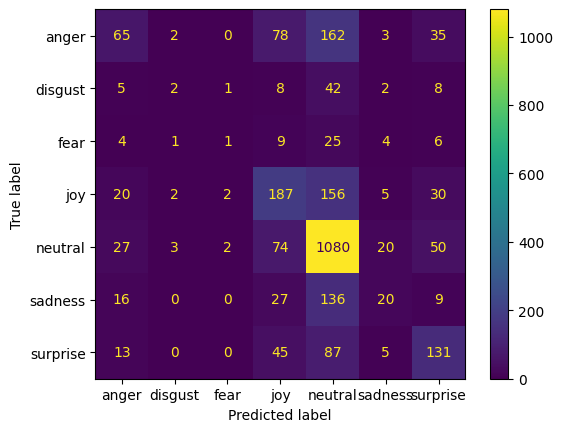

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay
print('Confusion matrix SVM')
print(svm_linear_clf.classes_)
cf_matrix_svm = sklearn.metrics.confusion_matrix(test_labels,y_pred_svm)
print(cf_matrix_svm)
import matplotlib.pyplot as plt
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_svm, display_labels=svm_linear_clf.classes_)
display.plot()

The diagonals represent the correctly classified test utterances. All others indicate the confusions, where another class was wrongly assigned. It is clear the neutral column has most results not only for the True label neutral but also the other rows. Besides the dominance of `neutral`, we see that `anger` spills a bit into `joy`, `sadness` and `neutral`. Furthermore, note that `surprise` is confused with both `anger` and `joy`. This makes sense because you can be surprised in a positive and negative way. Think a minute how the sentiment labels in MELD may help here. How would you fix this?  

## 3. Visualising the data <a class="anchor" id ="section3"></a> 

There are many ways and packages for visualising data. Data visualisation is important because it may show **biases** or inspire **baseline** approaches. Data **biases** can make your system overfit to certain dominant classes and make it hard to detect rare cases. A **baseline** system is a solid and simple approach against which you want to compare your trained system. Typical baselines are:  assign **random classes** as output or always assign the most dominant **majority class**. Let's see what the majority class is in our data. Don't worry too much understanding the next code as long as you can use it.

To visualise data distributions, we use the **seaborn** package: https://seaborn.pydata.org/index.html

Seaborn can do fancy data visualisations. Checkout the website to learn more.
For now, we will use a simple function that you can apply to a column in a Pandas dataframe.

If you did not install it yet, you need to install the package. Otherwise, you can skip the next cell.

In [8]:
#!pip install seaborn

If the installation is succesful, we can import it in this notebook as **sns**.

In [9]:
import seaborn as sns

Seaborn can create a figure directly from a column in a Pandas dataframe using the **countplot** function:

<Axes: xlabel='Emotion', ylabel='count'>

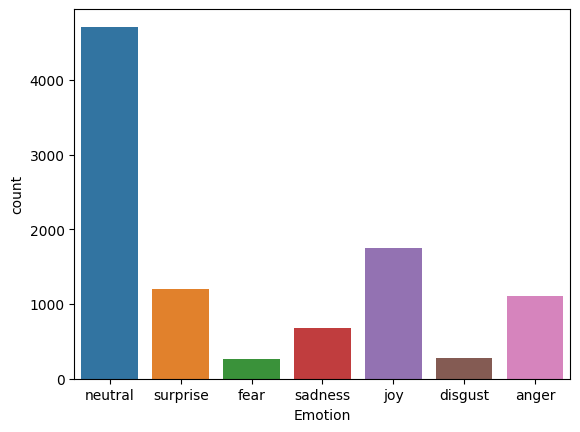

In [10]:
sns.countplot(x=dftrain['Emotion'])

This figure is rather basic. We do not see the totals of each category and need to guess the counts by eye-balling it. We want to get the proportions for these labels.

To add more information to the figure, we will use another package called **matplotlib**. There are many options and functions you can use to modify and adapt plots using **matplotlib**. We will show only a few here. You can read more about setting parameters for plotting figures here: https://matplotlib.org/stable/tutorials/introductory/customizing.html 

If not installed, install **matplotlib** in the usual way if you have not done so before. Otherwise, you can skip the next cell.

In [27]:
#%conda install matplotlib

#or

#pip install matplotlib

After succesful installation, we can import it as 'plt': 

In [11]:
import matplotlib.pyplot as plt

We need some code to first count how frequently emotion labels are assigned and next get their proportional values. First, we can get the counts for the Emotion values from the corresponding Pandas column. For this we use the **Counter** function of Python. This gives a dictionary with the values and their counts. From this dictionary we can get all the keys and values as lists.  The **Counter** class creates a dictionary with the keys in random order. We use another function **OrderedDict** to sort the keys alphabetically.

In [12]:
from collections import Counter, OrderedDict
counts = Counter(dftrain['Emotion'])
counts_sorted = OrderedDict(sorted(counts.items()))
print(counts_sorted)
labels = list(counts_sorted.keys())
values = list(counts_sorted.values())
print(labels, values)

OrderedDict([('anger', 1109), ('disgust', 271), ('fear', 268), ('joy', 1743), ('neutral', 4710), ('sadness', 683), ('surprise', 1205)])
['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'] [1109, 271, 268, 1743, 4710, 683, 1205]


To make things easier, we defined a function called **plot_labels_with_counts** that takes the labels and values and plots them as bars using **Seaborn** while augmenting the bars with the proportion out of the total. We added this function to the **lab3_util.py** file that you need to import as **util**, so you can call it using **util.plot_labels_with_counts**.

/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


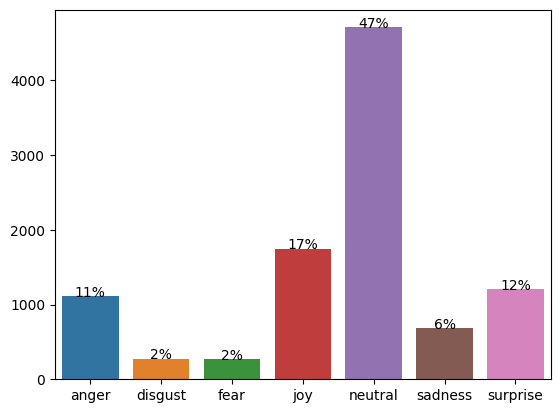

In [13]:
import lab3_util as util
util.plot_labels_with_counts(labels, values)

Now, we have the proportions on top of the bars. We clearly see that the emotions are not equally distributed over the utterances. Most utterances are `neutral` (47%) and `fear` and `disgust` are rare. It is important to realize this when training and testing the classifier.

On the basis of the stats for the emotion values, we can already have expectations for what a machine will learn from this data: **assign the class neutral!**

A possible majority class baseline would be to always assign `neutral`. We will try that below.

Let us see if the test data has a similar distribution:

OrderedDict([('anger', 345), ('disgust', 68), ('fear', 50), ('joy', 402), ('neutral', 1256), ('sadness', 208), ('surprise', 281)])


/Users/piek/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


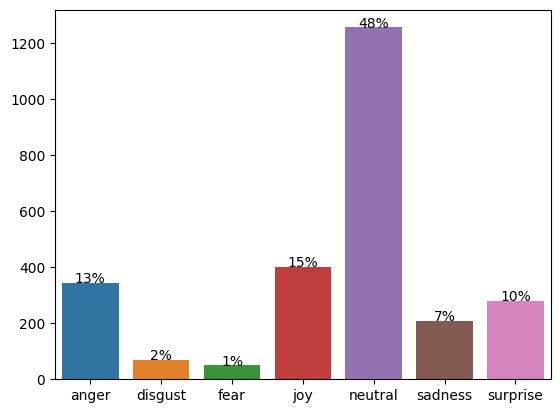

In [14]:
counts = Counter(dftest['Emotion'])
counts_sorted = OrderedDict(sorted(counts.items()))
print(counts_sorted)
labels = list(counts_sorted.keys())
values = list(counts_sorted.values())
util.plot_labels_with_counts(labels, values)

We see that the test data is similar in terms of the distribution of emotions. This means that statistical expectations learned from the training data will be relevant for the test data. A ```neutral``` baseline always assigns the class neutral and will be correct in 48% of the cases.

Think about this for a moment. Is this good or bad? For science or for applications?

We want to build a model that performs better than this baseline. Anything performing at this level or lower did not learn much or the wrong things.

In order to train a model to test against the baseline, we need to get all the utterances and the corresponding labels. For this we need to iterate over the Pandas data frame. The next section shows how we can do that.


### 5.2 Balancing training data <a class="anchor" id ="section5.2"></a> 

Our system performs just above the baseline of the dominant class *neutral*: .48. What can you do if one class is so dominant?

Well, we can simply reduce the training data for the dominant class. The next code iterates over the rows in the dataframe and separately gets the utterance and label. To get the label that goes with the utterance, we need to pass the row index that goes with each utterance in the **iloc** function of the Emotion column. We use a general Python **enumerate** function to simultaneously get the utterance and the row index from the list of utterances in the Utterance column.

In [52]:
## With sample we define how many training cases we want to skip to select the next training item
## If set to 5 we take 1 out of 5
sample = 5

balanced_training_instances=[]
balanced_training_labels=[]

cnt_neutral = 0
for row_nr, utterance in enumerate(dftrain['Utterance']):
    emotion_label = dftrain['Emotion'].iloc[row_nr] # this reads as from the column 'Emotion' take the value from the row located at 'row_nr'
    if emotion_label =='neutral':
        cnt_neutral += 1
        if cnt_neutral % sample == 0:  ### this checks if the count is dividable by the value of sample (no leftover)
            balanced_training_instances.append(utterance)
            balanced_training_labels.append(emotion_label)
    else:
        balanced_training_instances.append(utterance)
        balanced_training_labels.append(emotion_label)

In [53]:
balanced_df = pd.DataFrame(balanced_training_labels, columns = ['Emotion'])
print(balanced_df.info())
print(balanced_df.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Emotion  6221 non-null   object
dtypes: object(1)
memory usage: 48.7+ KB
None
     Emotion
0   surprise
1    neutral
2       fear
3    neutral
4   surprise
5   surprise
6    sadness
7   surprise
8       fear
9    neutral
10       joy
11   sadness
12  surprise
13   disgust
14   sadness


['joy', 'surprise', 'anger', 'neutral', 'sadness', 'disgust', 'fear'] [1743, 1205, 1109, 942, 683, 271, 268]


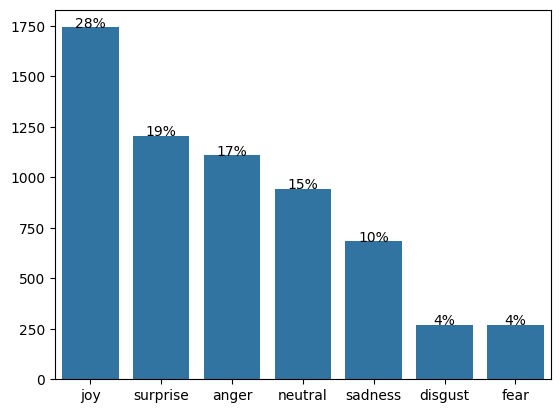

In [54]:
counts = balanced_df.Emotion.value_counts()
labels = counts.index.to_list()
values = counts.to_list()
print(labels, values)
util.plot_labels_with_counts(labels, values)

Will this work? Figure it out your self by retraining and testing a classifier.

# End of this notebook